# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [188]:
# Install the required libraries
!pip install prophet

In [189]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt # ChatGPT : Code Pilot recommeded I include this, too...so that I can have greater functionality with my plots

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [190]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-190-217fb1a948ac>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [191]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Axes: title={'center': 'Search Trends'}, xlabel='Date'>

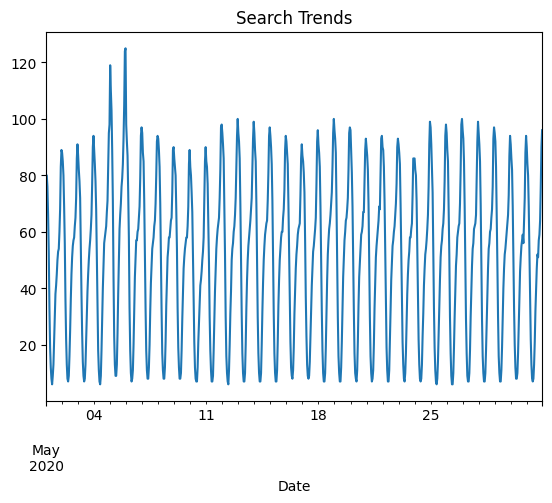

In [192]:
# Slice the DataFrame to just the month of May 2020
df_may_2020_data = df_mercado_trends["Search Trends"].loc["2020-05"]

# Plot to visualize the data for May 2020
df_may_2020_data.plot(title="Search Trends")
# I was able to get the graph and titles on the graph, but I could not figure out how to get the title so show up inside the graph.
# My instructor (Bill) and TA (Sean)) helped me refine this piece of code.

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [193]:
# Calculate the sum of the total search traffic for May 2020
total_search_traffic_may_2020 = df_may_2020_data.sum()

# View the traffic_may_2020 value
print("Total Search Trends for May 2020:", total_search_traffic_may_2020)
df_may_2020_data.dtypes
# My instructor (Bill) and TA (Sean)) helped me refine this piece of code.
# I also referred to past inclass activities with examples

Total Search Trends for May 2020: 38181


dtype('int64')

In [194]:
# Calcluate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions

# Group by year and month and calculate the median of 'Search Trends' column
monthly_median_traffic = df_mercado_trends['Search Trends'].groupby(
    [df_mercado_trends.index.year, df_mercado_trends.index.month]
).sum().median()
# My instructor (Bill) and TA (Sean)) helped me refine this piece of code. I had been trying to put the .sum() in the wrong location within the code

# View the median_monthly_traffic value
print("Median Monthly Traffic:", monthly_median_traffic)

# Check the data types of the df_may_2020_data DataFrame
df_may_2020_data.dtypes


Median Monthly Traffic: 35172.5


dtype('int64')

In [195]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
total_search_traffic_may_2020/monthly_median_traffic
# My instructor (Bill) and TA (Sean)) helped me refine this piece of code in an after class session

1.0855355746677091

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes. The month of May 2020 (when MercadoLibre released its quarterly financial results) shows an increase in search traffic when compared to the average number of searchs (traffic) on a montly basis. Median Monthly Trafficfor all months = 35172.5 vs Median Monthly Traffic for May 2020 = 38181. This is a statistically significant increase in traffic/searches at 1.08.  There are 2 days in May (the 5th and 6th) where the majority of the traffic search increases occured.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

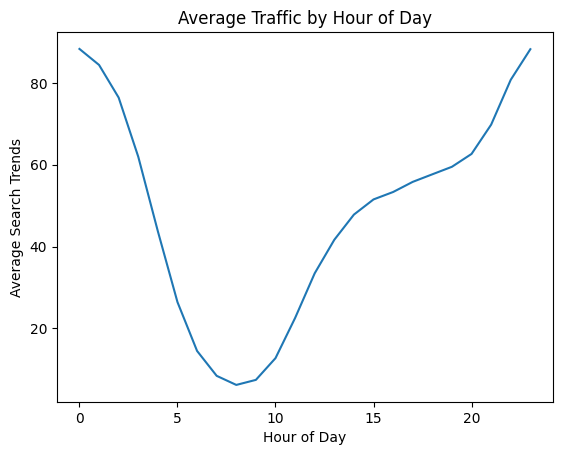

In [196]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
# Note: this code was suggested and generated automatically by google colab. The output is consistent with the required output. The coding is consistent with the recommendations from ChatGPT:Code Copilot.
# I'm amazed at how quickly it generated this code and how it read the prior code and took it into account.

# Group the hourly search data to plot (use the `.groupby()` function) the average traffic by the hour of the day

# Extract the hour from the index
df_mercado_trends['Hour'] = df_mercado_trends.index.hour

# Group by hour and calculate the mean search trends
hourly_average_traffic = df_mercado_trends.groupby('Hour')['Search Trends'].mean()

# Plot the hourly average traffic
hourly_average_traffic.plot(title='Average Traffic by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Search Trends')
plt.show()



#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

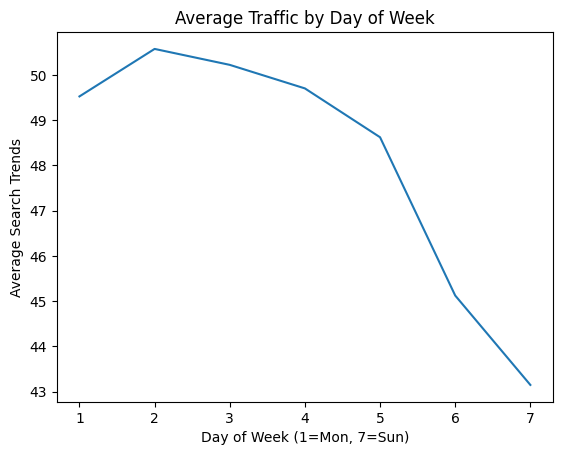

In [197]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
# this code, too was AI generated within colab
# prompt: # Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.

# Extract the day of the week from the index
df_mercado_trends['DayOfWeek'] = df_mercado_trends.index.isocalendar().day

# Group by day of the week and calculate the mean search trends
daily_average_traffic = df_mercado_trends.groupby('DayOfWeek')['Search Trends'].mean()

# Plot the daily average traffic
daily_average_traffic.plot(title='Average Traffic by Day of Week')
plt.xlabel('Day of Week (1=Mon, 7=Sun)')
plt.ylabel('Average Search Trends')
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

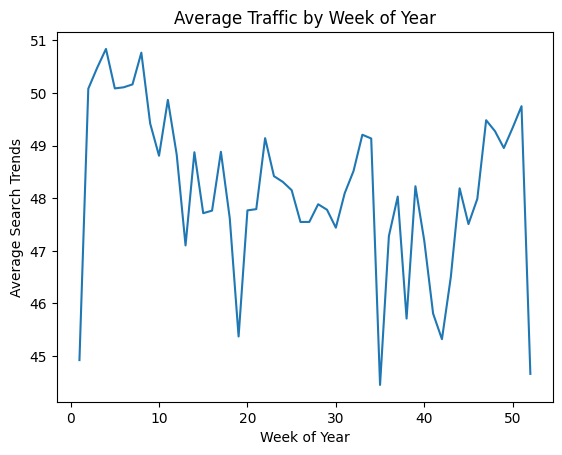

In [198]:
# This code was generated by Colab using their integrated AI tool. Super cool!  I did review the code for accuracy prior to accepting it.
# prompt: # Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.

# Extract the week of the year from the index
df_mercado_trends['WeekOfYear'] = df_mercado_trends.index.isocalendar().week

# Group by week of the year and calculate the mean search trends
weekly_average_traffic = df_mercado_trends.groupby('WeekOfYear')['Search Trends'].mean()

# Plot the weekly average traffic
weekly_average_traffic.plot(title='Average Traffic by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Search Trends')
plt.show()



##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** Yes. The graphs indicate that the busiest time for searches is between 2200 and 0300 (or 10pm and 3am) with the greatest number occuring around midnight, with an average of greater than 80 searches. Tuesday has the highest average number of searches, at greater than 50 searches. The first 10 weeks of the year have the greatest number of searches. It is difficult to tell exactly, but it appears that weeks 2-4 (end of January) and 6-8 (middle of February to first part of March) have the most searches. A more detailed graph would allow more detailed analysis.


## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [199]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


<Axes: title={'center': 'MercadoLibre Closing Price'}, xlabel='date'>

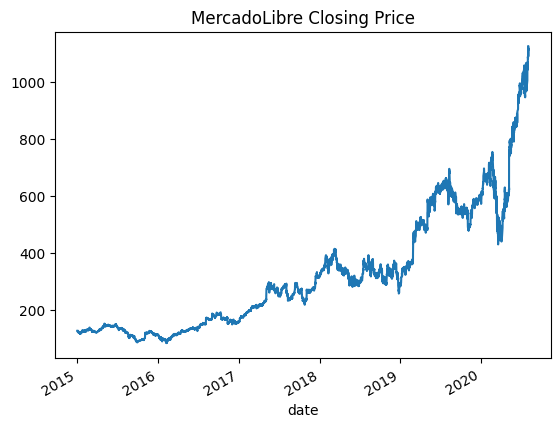

In [200]:
# Code generated by AI tool in Colab. Reviewed for accuracy and accepted.
# prompt: # Visualize the closing price of the df_mercado_stock DataFrame
#  Plot the closing price of MercadoLibre

# Visualize the closing price of the df_mercado_stock DataFrame

# Plot the closing price of MercadoLibre
df_mercado_stock['close'].plot(title="MercadoLibre Closing Price")


In [201]:
## This code was auto generated by AI tool in Colab. Reviewed for accuracy and accepted.
# prompt: # Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# # Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
# # View the first and last five rows of the DataFrame

# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
mercado_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(mercado_df.head())
display(mercado_df.tail())



,close,Search Trends,Hour,DayOfWeek,WeekOfYear
2016-06-01 09:00:00,135.16,6.0,9.0,3,22
2016-06-01 10:00:00,136.63,12.0,10.0,3,22
2016-06-01 11:00:00,136.56,22.0,11.0,3,22
2016-06-01 12:00:00,136.42,33.0,12.0,3,22
2016-06-01 13:00:00,136.10,40.0,13.0,3,22


,close,Search Trends,Hour,DayOfWeek,WeekOfYear
2020-07-31 11:00:00,1105.780,20.0,11.0,5,31
2020-07-31 12:00:00,1087.925,32.0,12.0,5,31
2020-07-31 13:00:00,1095.800,41.0,13.0,5,31
2020-07-31 14:00:00,1110.650,47.0,14.0,5,31
2020-07-31 15:00:00,1122.510,53.0,15.0,5,31


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [202]:
## Code generated by AI Tool in colab. I reviewed and verified the code prior to accepting it.
# prompt: # For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
# # View the first and last five rows of first_half_2020 DataFrame

# Slice the data to just the first half of 2020
first_half_2020 = mercado_df.loc['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())



,close,Search Trends,Hour,DayOfWeek,WeekOfYear
2020-01-02 09:00:00,601.085,9.0,9.0,4,1
2020-01-02 10:00:00,601.290,14.0,10.0,4,1
2020-01-02 11:00:00,615.410,25.0,11.0,4,1
2020-01-02 12:00:00,611.400,37.0,12.0,4,1
2020-01-02 13:00:00,611.830,50.0,13.0,4,1


,close,Search Trends,Hour,DayOfWeek,WeekOfYear
2020-06-30 11:00:00,976.17,17.0,11.0,2,27
2020-06-30 12:00:00,977.50,27.0,12.0,2,27
2020-06-30 13:00:00,973.23,37.0,13.0,2,27
2020-06-30 14:00:00,976.50,45.0,14.0,2,27
2020-06-30 15:00:00,984.93,51.0,15.0,2,27


array([<Axes: >, <Axes: >], dtype=object)

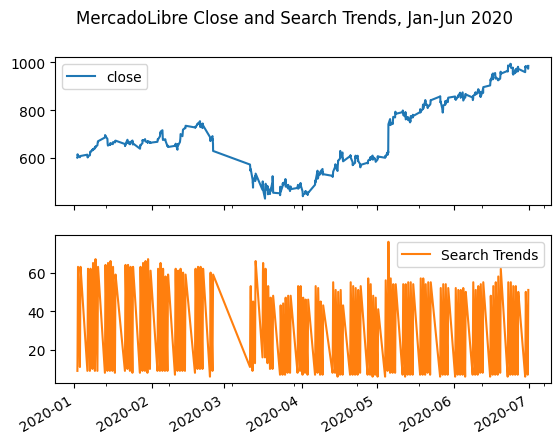

In [203]:
## Code was generated with the embedded AI tool. I reviewed and verified the code prior to accepting it.
# prompt: # Visualize the close and Search Trends data
# # Plot each column on a separate axes using the following syntax
# # `plot(subplots=True)`

# Plot the 'close' and 'Search Trends' columns on separate axes
first_half_2020[['close', 'Search Trends']].plot(subplots=True, title= "MercadoLibre Close and Search Trends, Jan-Jun 2020")


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**Yes. Although Covid 19 began in China in Nov 2019, it did not hit the United States significantly until the beginning of March 2020. This date - March 2020 - is reflected in the data and graphs. The impact of Covid-19 was World wide. Travel and intercommerce ceased for a time. Businesses were forced to shutter and the stock market plunged. This is reflected in the graphs and numbers in this data. Within a few days the government stepped in and provided support by means of decreasing interest rates, grants and direct payments which took a matter of weeks to impact individuals and businesses. This resulted in a recovery of the stockmarket. The rapid stockmarket rebound is also reflected in the numbers and the graphs. Commonly when there are crashes it is the result of loss of confidence more than a loss of actual capitol. However, in the case of COVID-19, there was an actual shutdown of many aspects of the economoy and actual loss of jobs, capitol and the impact on the economy was tremendous.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [204]:
## code was generated with the embedded AI tool. I reviewed and verified the code prior to accepting it.
# prompt: # Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# # This column should shift the Search Trends information by one hour

# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour

mercado_df['Lagged Search Trends'] = mercado_df['Search Trends'].shift(1)

In [205]:
## Code was generated with the embedded AI tool. I reviewed and verified the code prior to accepting it.
# prompt: # Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# # This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

mercado_df['Stock Volatility'] = mercado_df['close'].pct_change().rolling(window=4).std()

<Axes: title={'center': 'MercadoLibre Stock Volatility'}>

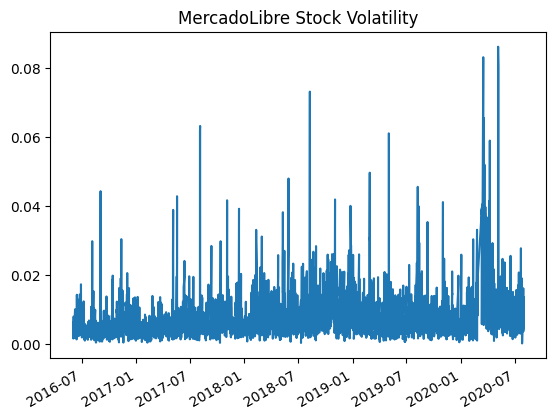

In [206]:
## Code was generated with the embedded AI tool. I reviewed and verified the code prior to accepting it.
# prompt: # Visualize the stock volatility

# Plot the stock volatility
mercado_df['Stock Volatility'].plot(title='MercadoLibre Stock Volatility')

# Visualize the stock volatility


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [207]:
## Code was generated with the embedded AI tool. I reviewed and verified the code prior to accepting it.
# prompt: # Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# # This column should calculate hourly return percentage of the closing price

# Create a new column in the mercado_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_df['Hourly Stock Return'] = mercado_df['close'].pct_change()


In [208]:
## Code was generated with the help of the embedded AI tool. I reviewed and verified the code. in this instance, the code appeared as a prompt on its own in light gray, and I accepted it
#I did check to see if the columns the code added above were present in the DataFrame.
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_df.head())
display(mercado_df.tail())


,close,Search Trends,Hour,DayOfWeek,WeekOfYear,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,9.0,3,22,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,10.0,3,22,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,11.0,3,22,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,12.0,3,22,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,13.0,3,22,33.0,0.006134,-0.002346


,close,Search Trends,Hour,DayOfWeek,WeekOfYear,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,5,31,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,12.0,5,31,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,13.0,5,31,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,14.0,5,31,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,15.0,5,31,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [209]:
# Given code.
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return

# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()


,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**No.There does not appear to be any coorelation between Stock Volatility, Lagged Search Trends and/ or Hourly Stock Return. The numbers that are perfectly coorelated (1.0) are where they are coorelated with themselves. Other numbers show no coorelation.


## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [210]:
# Just checking to see the contents of the DataFrame

display(mercado_df.head())
display(mercado_df.tail())


,close,Search Trends,Hour,DayOfWeek,WeekOfYear,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,9.0,3,22,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,10.0,3,22,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,11.0,3,22,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,12.0,3,22,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,13.0,3,22,33.0,0.006134,-0.002346


,close,Search Trends,Hour,DayOfWeek,WeekOfYear,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,5,31,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,12.0,5,31,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,13.0,5,31,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,14.0,5,31,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,15.0,5,31,47.0,0.013566,0.010678


In [211]:
## although I used Colab to help with the code, I found that it was not accurate. I tried ChatGPT and Xpert. They were somewhat helpful, but
# still did not provide all the code needed to produce the required output. So I continued to refine the code on my own to achieve the required output.

# Step 1: Reset the index so that the date information is no longer the index
df_mercado_trends.reset_index(inplace=True)

# Step 2: Rename the columns to ds (date) and y (target value) for Prophet
# Assuming the date column is now called 'date' and the target column is named 'value'
# Replace 'date' and 'value' with the actual column names from your DataFrame
df_mercado_trends = df_mercado_trends.rename(columns={'Date': 'ds', 'Search Trends': 'y'})

# Step 3: Drop any NaN values
mercado_prophet_df = df_mercado_trends.dropna()

# Step 4: View the first and last five rows of the DataFrame
print("First five rows:")
print(mercado_prophet_df.head())

print("\nLast five rows:")
print(mercado_prophet_df.tail())


First five rows:
                   ds   y  Hour  DayOfWeek  WeekOfYear
0 2016-06-01 00:00:00  97     0          3          22
1 2016-06-01 01:00:00  92     1          3          22
2 2016-06-01 02:00:00  76     2          3          22
3 2016-06-01 03:00:00  60     3          3          22
4 2016-06-01 04:00:00  38     4          3          22

Last five rows:
                       ds   y  Hour  DayOfWeek  WeekOfYear
37101 2020-09-07 20:00:00  71    20          1          37
37102 2020-09-07 21:00:00  83    21          1          37
37103 2020-09-07 22:00:00  96    22          1          37
37104 2020-09-07 23:00:00  97    23          1          37
37105 2020-09-08 00:00:00  96     0          2          37


In [212]:
# Although the instructions don't mention dropping columns, the visual output does not include the columns Hour, DayOfWeek or WeekOfYear
# I developed the prompt and Colab AI prompted with the code listed below. I reviewed and approved the code.
# Prompt: Drop columns Hour, DayOfWeek & WeekOfYear, level_0 and index.

# Drop the 'Hour', 'DayOfWeek' and 'WeekOfYear' columns
mercado_prophet_df = mercado_prophet_df.drop(columns=['Hour', 'DayOfWeek', 'WeekOfYear'])
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())


,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [213]:
# Call the Prophet function, store as an object
model_mercado_trends = Prophet()
model_mercado_trends


In [214]:
# Colob generated this code. I reviewed and accepted it.
# prompt: # Fit the time-series model.

# Fit the time-series model.
model_mercado_trends.fit(mercado_prophet_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdh4gxolm/u6r8ezfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdh4gxolm/qmxlj1ci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=852', 'data', 'file=/tmp/tmpdh4gxolm/u6r8ezfd.json', 'init=/tmp/tmpdh4gxolm/qmxlj1ci.json', 'output', 'file=/tmp/tmpdh4gxolm/prophet_model__bgg5as/prophet_model-20240906024822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:48:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:48:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [215]:
# Colab created this code based on the prompt. I reviewed and accepted this code.
# prompt: Create a future dataframe to hold predictions
# # Make the prediction go out as far as 2000 hours (approx 80 days)
# # View the last five rows of the future_mercado_trends DataFrame

future_mercado_trends = model_mercado_trends.make_future_dataframe(periods=2000, freq='H')
display(future_mercado_trends.tail())


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [216]:
# Colab AI generated this code based on the prompt below. I reviewed and accepted this code.
# prompt: # Make the predictions for the trend data using the future_mercado_trends DataFrame
# # Display the first five rows of the forecast_mercado_trends DataFram

forecast_mercado_trends = model_mercado_trends.predict(future_mercado_trends)
display(forecast_mercado_trends.head())


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,81.033242,98.187171,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,78.212650,95.005244,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.786476,84.070786,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,51.974782,69.147653,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,34.494010,52.429402,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


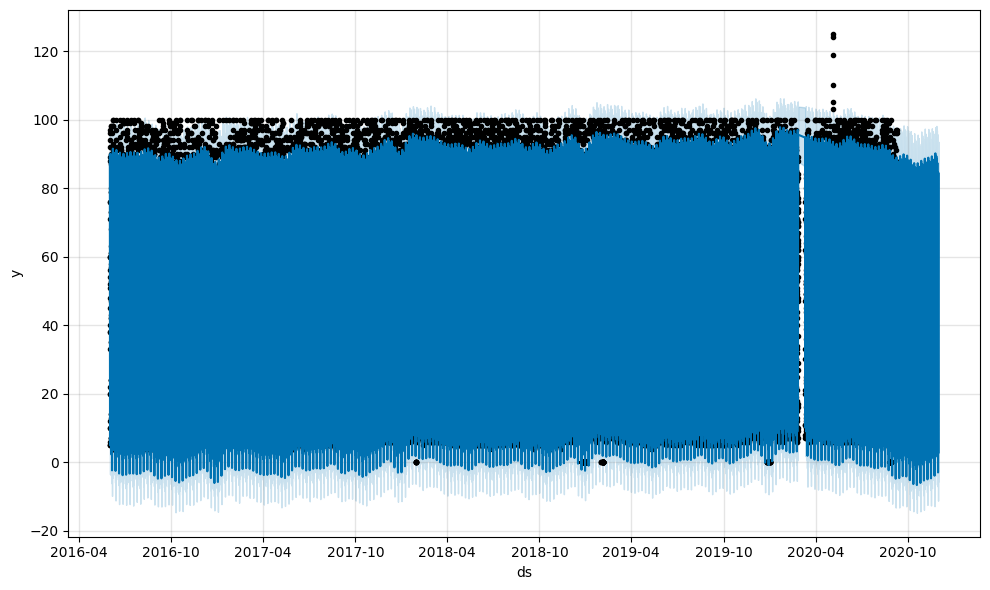

In [217]:
# Colab AI generated this code based on the prompt below. I reviewed and accepted this code.
# prompt: # Plot the Prophet predictions for the Mercado trends data

# Plot the Prophet predictions for the Mercado trends data
model_mercado_trends.plot(forecast_mercado_trends)
plt.show()


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** The near-term forecast shows it continues with a slight downward trend followed by a slight upward trend. It appears that it might be forcasting the start of a recovery (upward trend). This graph was harder for me to read and understand because of the shear volume of data represented.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [218]:
# Code was generated using Colab AI tool. I reviewed and accepted this code.
# prompt: # Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
# # View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame

# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast_mercado_trends.set_index('ds')

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
#print(forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']])

forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]

,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.629222,81.033242,98.187171
2016-06-01 01:00:00,86.075935,78.212650,95.005244
2016-06-01 02:00:00,75.753361,67.786476,84.070786
2016-06-01 03:00:00,60.487045,51.974782,69.147653
2016-06-01 04:00:00,43.373051,34.494010,52.429402
...,...,...,...
2020-11-30 04:00:00,39.781638,31.955015,48.903258
2020-11-30 05:00:00,24.310504,16.020779,32.756787
2020-11-30 06:00:00,12.344836,3.728698,21.140298


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

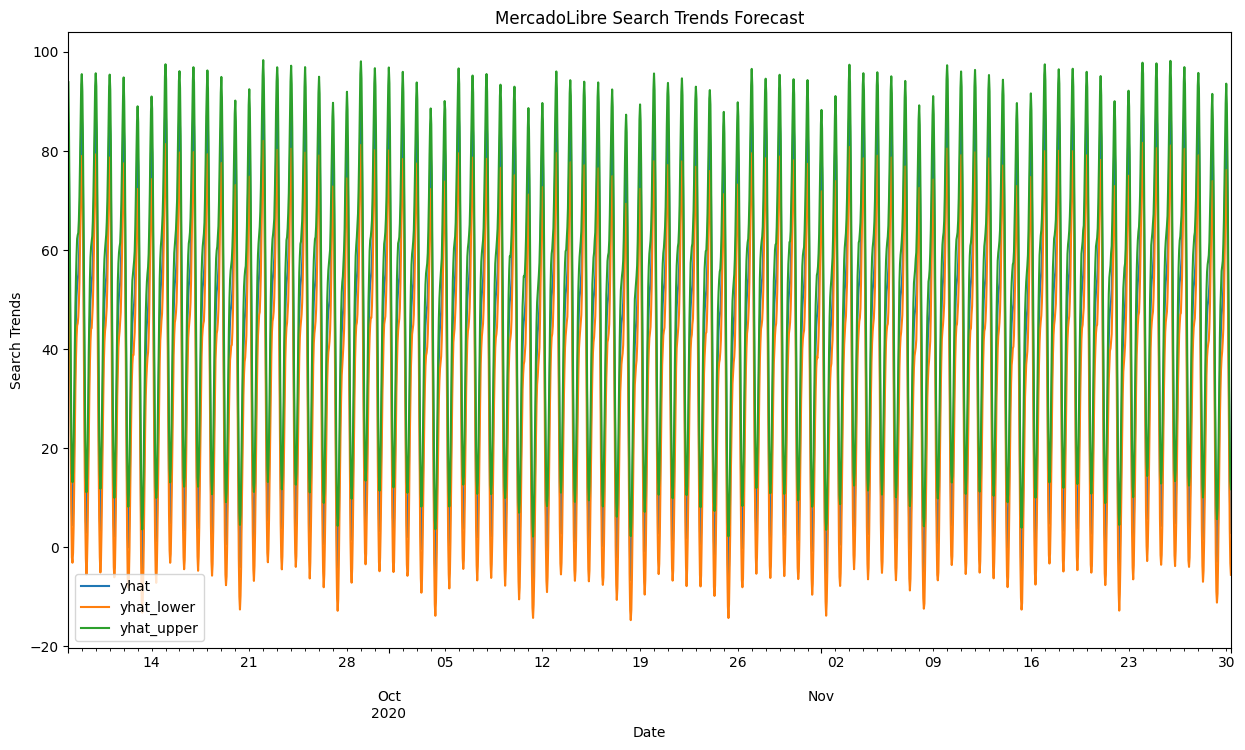

In [219]:
# I used Colab AI tool to generate this code based on the prompt below. I reviewed and accepted this code.
# prompt: # From the forecast_mercado_trends DataFrame, plot the data to visualize
# #  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours

# Plot the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].tail(2000).plot(figsize=(15, 8))
plt.title('MercadoLibre Search Trends Forecast')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.show()


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

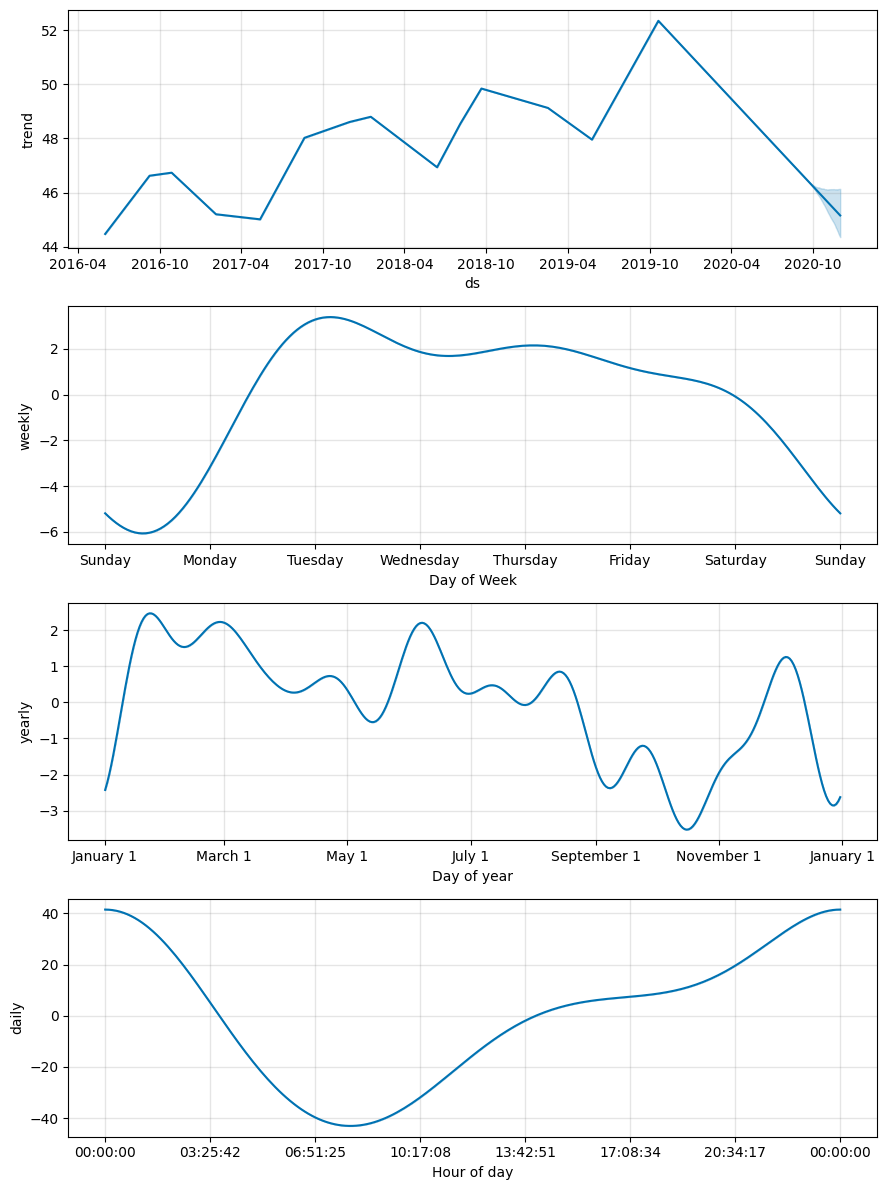

In [220]:
# I used Colab to create this code based on this prompt. I reviewed and accepted this code.
# prompt: # Reset the index in the forecast_mercado_trends DataFrame
# # Use the plot_components function to visualize the forecast results
# # for the forecast_canada DataFrame

# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
model_mercado_trends.plot_components(forecast_mercado_trends)
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** 00:00:00 (or midnight) is the most popular time of day for searches


**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday gets the most search traffic

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** October is the month (appears to me to be the latter half of October) with the lowest point / amount of search traffic.

